# Sentiment Analisys

This notebook shows different methods to represent the input text and we will use sentiment analysis as a demonstration.

We will use a subset of this Steam Review dataset (https://www.kaggle.com/datasets/andrewmvd/steam-reviews) which contains game reviews and a review score (-1 for negative and +1 for positive).

We will use small neural networks implemented in PyTorch, which is the most commonly used library for this kind of tasks. The focus is not the neural networks or PyTorch, so we will keep it simple.

## Setup

If you are using Google Colab, select the GPU runtime (Runtime > Change Runtime Type > T4 GPU). The notebook should run in a reasonable time even on CPU.

Then we need to install these libraries.

If you run this notebook locally:
1.    create a virtual environment to keep this project separated from all the others: `python -m venv nlp-venv`
1.   Activate it: `source nlp-venv/bin/activate`
1.   Install the required packages: `pip install ipykernel jupyter torch scikit-learn pandas numpy tqdm fasttext sentencepiece`

If you are on Windows, activating the environment should be something like this:
```
Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope CurrentUser
nlp-venv\Scripts\activate
```

To uninstall the environment (and free some space), simply remove the folder `nlp-env`.

In [1]:
!pip install torch scikit-learn pandas numpy tqdm fasttext sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498211 sha256=01d8504fc70c2fbf95bcff73c0679b809fde8aa544eeb772746d2d2781c5a594
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [2]:
import os
import functools

import re # Regular expressions
import unicodedata # Character normalization


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.metrics

from tqdm.notebook import tqdm # Loading bars

import fasttext # Fasttext embeddings

import io # BytesIO/StringIO (~in-memory files)
import sentencepiece as spm # BPE and UnigramLM tokenizers

## Load the data

First, we download the train set and the test set.
They are csv files with two columns: `review_text` and `review_score`.
`review_score` contains -1 for negative and +1 for positive, but we will change it to 0 and 1. In this way we can interpret it as probability of the text being positive.

The test set must not be used for training the model or finding any hyper parameter.

You can find the data here: https://ufallab.ms.mff.cuni.cz/~vico/NPFL129-2526/. There are train sets with 2_000, 20_000, and 200_000 samples, and the test set with 2_000 samples. Half of the samples are positive, helf are negetice.

The original dataset is from here: https://www.kaggle.com/datasets/andrewmvd/steam-reviews/data

In [3]:
!wget https://ufallab.ms.mff.cuni.cz/~vico/NPFL129-2526/steam_test.csv
!wget https://ufallab.ms.mff.cuni.cz/~vico/NPFL129-2526/steam_train_1000.csv

--2025-11-07 10:24:40--  https://ufallab.ms.mff.cuni.cz/~vico/NPFL129-2526/steam_test.csv
Resolving ufallab.ms.mff.cuni.cz (ufallab.ms.mff.cuni.cz)... 195.113.18.181
Connecting to ufallab.ms.mff.cuni.cz (ufallab.ms.mff.cuni.cz)|195.113.18.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708224 (692K) [text/csv]
Saving to: ‘steam_test.csv’

steam_test.csv      100%[===================>] 691.62K   921KB/s    in 0.8s    

2025-11-07 10:24:42 (921 KB/s) - ‘steam_test.csv’ saved [708224/708224]

--2025-11-07 10:24:42--  https://ufallab.ms.mff.cuni.cz/~vico/NPFL129-2526/steam_train_1000.csv
Resolving ufallab.ms.mff.cuni.cz (ufallab.ms.mff.cuni.cz)... 195.113.18.181
Connecting to ufallab.ms.mff.cuni.cz (ufallab.ms.mff.cuni.cz)|195.113.18.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 687012 (671K) [text/csv]
Saving to: ‘steam_train_1000.csv’

steam_train_1000.cs 100%[===================>] 670.91K   854KB/s    in 0.8s    

2025-11-07 

In [4]:
test_file = 'steam_test.csv'
train_file = 'steam_train_1000.csv'

test_df = pd.read_csv(test_file)
test_df['review_score'] = test_df['review_score'].apply(lambda x: 1 if x == 1 else 0)
train_df = pd.read_csv(train_file)
train_df['review_score'] = train_df['review_score'].apply(lambda x: 1 if x == 1 else 0)
train_df

,review_text,review_score
0,Initially the game is fairly basic but errupts...,1
1,Battlepillars is a cool tug-of-war game that h...,1
2,Laggy but Great,1
3,Very fun! A must try for everyone! Just be pre...,1
4,It's a awesome game and it was worth my money ...,1
...,...,...
1995,I'd rather ♥♥♥♥ out a batarang than play anymo...,0
1996,It's ok NOOOOO Left for dead or Dead Space but...,0
1997,Here's my specs for reference; Win7 64bit In...,0
1998,"All the trolling and stuck-up old men aside, t...",0


**What can we see from this sample?**

...

## Bag-of-Words approach

**How can we represent the reviews with different length?**

With a bag of word, we simply count how many times we see a word in the sentence.
This can be done with CountVectorizer from Sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) or TfidfVectorizer (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Firt we need to clean and normalise the text and then we can split it into words.

**Do we need capitalisation? Or punctuation? Should we remove some words (for example, 'and', 'the', 'not')? What about non-Latin characters?**

In [5]:
stop_words = ['the', 'to', 'and', 'a', 'of', 'is', 'i', 'game', 'you', 'it', '.', ',', 'this', 'that']
clean_re = r'[^a-zA-Z0-9 ]' # Remove non-latin/not number/not space
def my_tokenizer(review: str, stop_words) -> list[str]:
    # Split the review into words
    # and do other preprocessing steps
    review = unicodedata.normalize('NFKD', review)
    review = re.sub(clean_re, '', review)
    words = review.lower().strip().split()
    words = [i for i in words if i not in stop_words and len(i.strip()) != 0]
    return words
# TfidfVectorizer wants a tokenizer that takes a string and returns a list of string
tokenizer = functools.partial(my_tokenizer, stop_words=[])

# You can play with the parameters and see the effect on the model
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer=tokenizer,
    max_features=None, # Maximum vocabulary size
    binary=False, # only 0 and 1 instead of the actual counts
    use_idf=False, # Tf vs Tf-Idf
)

X_train = tfidf_vectorizer.fit_transform(train_df['review_text']).toarray() # Here we also train the bow
X_test = tfidf_vectorizer.transform(test_df["review_text"]).toarray() # Here we don't
y_train = train_df['review_score'].to_numpy(np.float32)
y_test = test_df['review_score'].to_numpy(np.float32)


Now our dataset is a matrix with shape (numer of examples, vocabulary size).

In [6]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Lat's see what are the most frequent terms.

Most frequent terms: ['the', 'game', 'and', 'a', 'to', 'review', 'early', 'access', 'i', 'it']
Least frequent terms: ['choking', 'canvas', 'boned', 'blessing', 'billionth', 'biggerbetter', 'barrel', 'assumption', 'apartments', 'ambiguous']


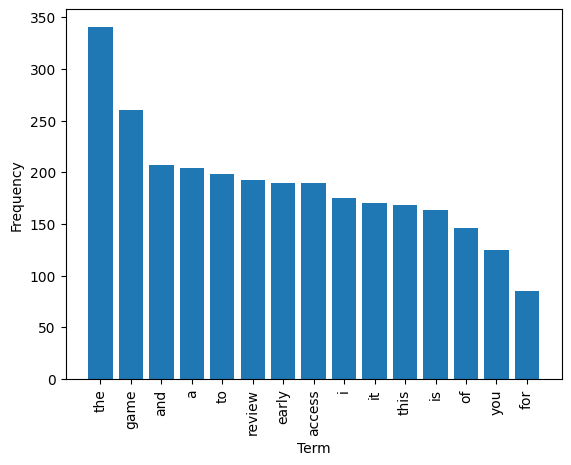

In [7]:
# Vocabulary: {term: id}
inv_vocab = {v:k for k,v in tfidf_vectorizer.vocabulary_.items()}
freq = X_train.sum(axis=0)
freq = [(f, inv_vocab[i]) for i,f in enumerate(freq.flat)]
freq = sorted(freq, reverse=True)
print("Most frequent terms:", [i[1] for i in freq[:10]])
print("Least frequent terms:", [i[1] for i in freq[-10:]])

n = 15
plt.bar([i[1] for i in freq[:n]], [i[0] for i in freq[:n]])
plt.ylabel("Frequency")
plt.xlabel("Term")
plt.xticks(rotation=90)
plt.show()

Let's define a simple neural network for this task.
The linear layer does this operation: $x^TW+b$.

$W^{(1)}$ has dimension (vocabulary size, hidden size), while $W^{(2)}$ has dimension (hidden size, hidden size). The weights of the last layer have dimension (hidden size, 1).

The model outputs logits, so we use the sigmoid function to have a probability distribution between 0 and 1.

**What happens if we change the number neurons, add more layers, add dropout, etc?**

In [8]:
class NN(nn.Sequential):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        # First layer
        self.add_module('layer_1', nn.Linear(input_size, hidden_size))

        # Non-linear activation function
        self.add_module('activation_1', nn.ReLU())

        # Second layer
        self.add_module('layer_2', nn.Linear(hidden_size, hidden_size))

        # Non-linear activation function
        self.add_module('activation_2', nn.ReLU())

        # Output layer (output the logits)
        self.add_module('output', nn.Linear(hidden_size, 1))

    def predict(self, X):
        """Returns p(review is positive)"""
        return torch.sigmoid(self(X))

    def count_parameters(self):
        """Returns the number of parameters in the model."""
        p = 0
        for parameter in self.parameters():
            p += parameter.numel()
        return p

We then define the training function.

In [9]:
def train(model, X, y, epochs=10, batch=64, *, no_tqdm=False):
    """
    Trains the model for a given number of epochs.

    Args:
        model: the neural network model to train.
        X: numpy array with shape (n_examples, n_features)
        y: reference labels with shape (n_examples,)
        epochs: the number of iterations over the dataset
        batch: size of the minibatches
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # Prepare the data
    n_examples = X.shape[0]
    X_train = torch.as_tensor(X).float().to(device)
    y_train = torch.as_tensor(y).float().to(device).reshape(-1, 1) # Column vector

    # Utilities from torch to iterate through the dataset
    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch)
    n_batches = len(train_dl)

    # Optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss (logits as input)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001) # Stochastic gradient descent

    losses = []
    accuracies = []
    for epoch in tqdm(range(epochs), total=epochs, desc="Epoch", disable=no_tqdm):
        epoch_loss = 0
        correct = 0
        for X_batch, y_batch in tqdm(train_dl, leave=False, desc="Batch", disable=no_tqdm):
            optimizer.zero_grad()
            y_pred = model(X_batch) # Forward
            loss = criterion(y_pred, y_batch)
            loss.backward() # Gradient
            optimizer.step()
            epoch_loss += loss.sum().item()
            correct += ((torch.sigmoid(y_pred) >= 0.5) == y_batch).sum().item()
        losses.append(epoch_loss / n_examples)
        accuracies.append(correct / n_examples)
    return model, losses, accuracies

def predict(model, X):
    """
    Makes predictions using the trained model.

    Args:
        model: the trained neural network model.
        X: the input data with shape (n_examples, n_features)

    Returns:
        A numpy array of predictions (probabilities).
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    # The entire dataset fits in memory
    X = torch.as_tensor(X).float().to(device)
    with torch.no_grad():
        outputs = model.predict(X)
        predictions = outputs.squeeze().cpu().type(torch.float32).numpy()
    return predictions

def plot_loss(losses: list[float], accuracies: list[float], title = None):
    fig, ax1 = plt.subplots()
    if title is not None:
        fig.suptitle(title)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('BCE Loss')
    ax1.plot(losses)
    ax2 = ax1.twinx()

    ax2.set_ylabel('Accuracy')
    ax2.plot(accuracies, color='orange')
    fig.tight_layout()
    plt.show()

def score(labels, predictions, threshold=0.5):
    # Classification report: precision, recall, f1-score
    y_pred = (predictions >= threshold).astype(int)
    y_true = labels.astype(int)
    target_names = ['negative', 'positive']
    print(sklearn.metrics.classification_report(y_true, y_pred, target_names=target_names))

    # Simple metric
    print("Accuracy:", sklearn.metrics.accuracy_score(y_true, y_pred))

    # Confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names).plot()
    plt.show()

Parameters: 5670913


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

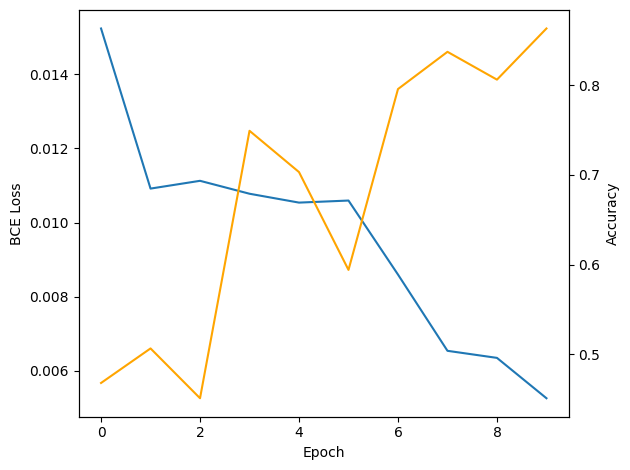

In [10]:
bow = NN(X_train.shape[1], 512)
print("Parameters:", bow.count_parameters())
bow, bow_losses, bow_accuracies = train(bow, X_train, y_train, epochs=10)
plot_loss(bow_losses, bow_accuracies)

              precision    recall  f1-score   support

    negative       0.62      0.96      0.76      1000
    positive       0.92      0.41      0.57      1000

    accuracy                           0.69      2000
   macro avg       0.77      0.69      0.66      2000
weighted avg       0.77      0.69      0.66      2000

Accuracy: 0.689


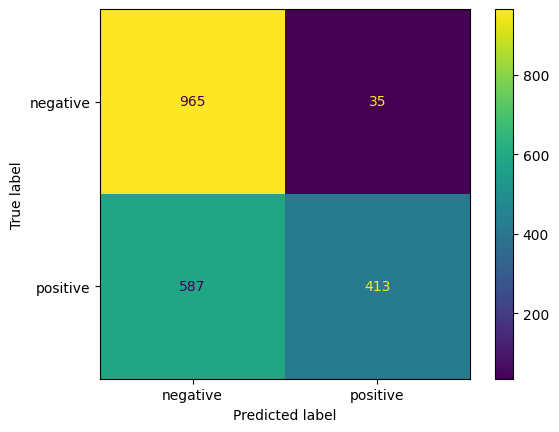

In [11]:
y_pred = predict(bow, X_test)
score(y_test, y_pred)

Let's put everything together and try some parameters.

In [12]:
def do_everything(title, train_df, test_df, use_idf, binary, max_features, tokenizer, epochs, threshold):
    tfidf_vectorizer = TfidfVectorizer(
        lowercase=True,
        analyzer=tokenizer,
        max_features=max_features, # Maximum vocabulary size
        binary=binary, # only 0 and 1 instead of the actual counts
        use_idf=use_idf, # Tf vs Tf-Idf
    )
    X_train = tfidf_vectorizer.fit_transform(train_df['review_text']).toarray() # Here we also train the bow
    X_test = tfidf_vectorizer.transform(test_df["review_text"]).toarray() # Here we don't
    y_train = train_df['review_score'].to_numpy(np.float32)
    y_test = test_df['review_score'].to_numpy(np.float32)

    bow = NN(X_train.shape[1], 512)
    bow, bow_losses, bow_accuracies = train(bow, X_train, y_train, epochs=epochs, no_tqdm=True)
    plot_loss(bow_losses, bow_accuracies, title)
    y_pred = predict(bow, X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred >= threshold)
    print('Accuracy:', acc)

**Which words have more or less in these setups?**

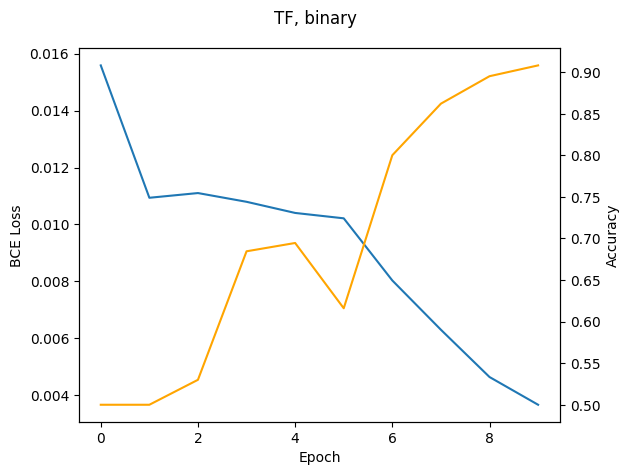

Accuracy: 0.738


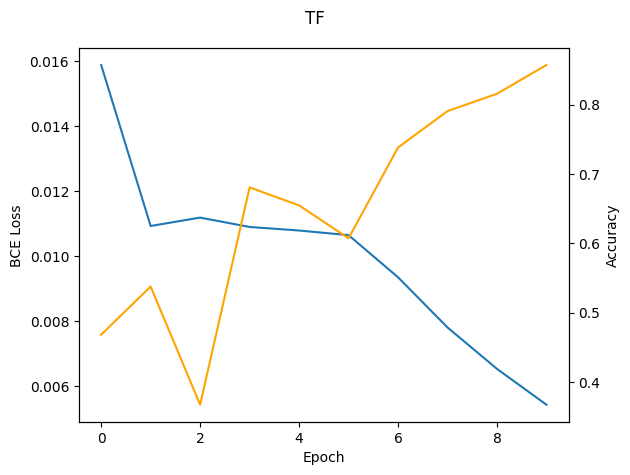

Accuracy: 0.6945


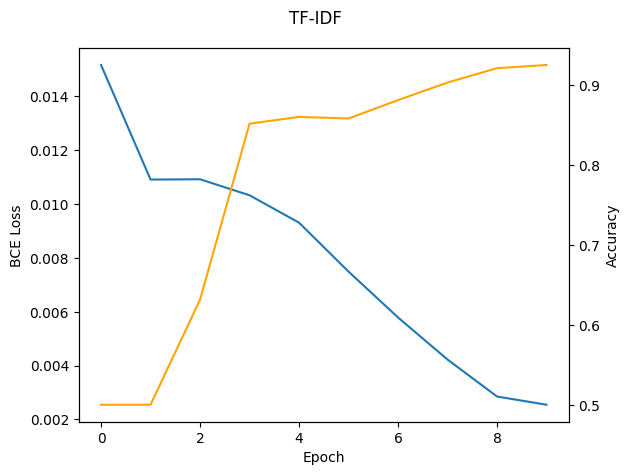

Accuracy: 0.7275


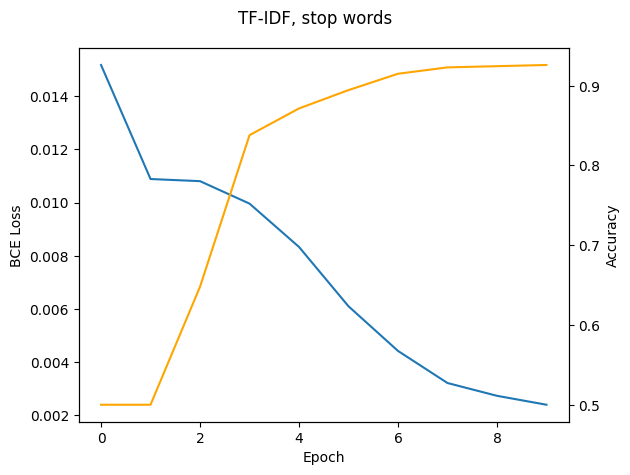

Accuracy: 0.7335


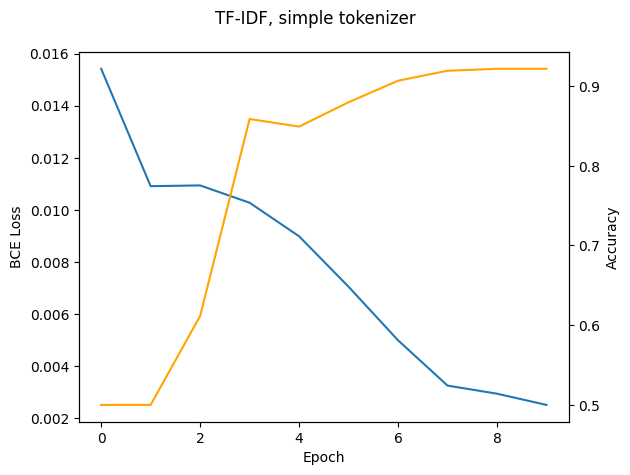

Accuracy: 0.712


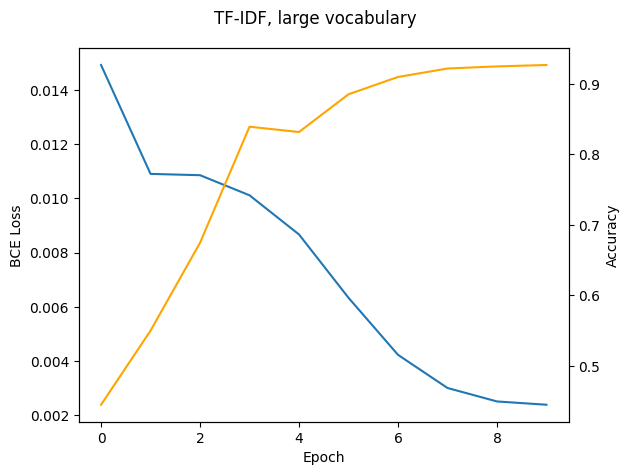

Accuracy: 0.7305


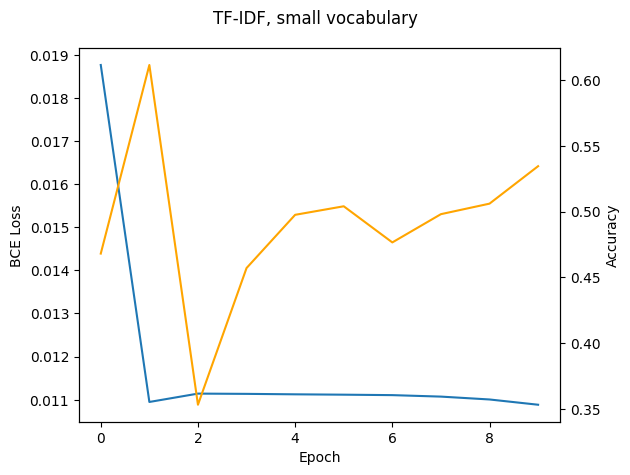

Accuracy: 0.641


In [13]:
tokenizer = functools.partial(my_tokenizer, stop_words=[])

do_everything('TF, binary', train_df, test_df, use_idf=False, binary=True, max_features=8000, epochs=10, threshold=0.5, tokenizer=tokenizer)
do_everything('TF', train_df, test_df, use_idf=False, binary=False, max_features=8000, epochs=10, threshold=0.5, tokenizer=tokenizer)
do_everything('TF-IDF', train_df, test_df, use_idf=True, binary=False, max_features=8000, epochs=10, threshold=0.5, tokenizer=tokenizer)
do_everything('TF-IDF, stop words', train_df, test_df, use_idf=True, binary=False, max_features=8000, epochs=10, threshold=0.5, tokenizer=functools.partial(my_tokenizer, stop_words=stop_words))
do_everything('TF-IDF, simple tokenizer', train_df, test_df, use_idf=True, binary=False, max_features=8000, epochs=10, threshold=0.5, tokenizer=str.split)
do_everything('TF-IDF, large vocabulary', train_df, test_df, use_idf=True, binary=False, max_features=1_000_000, epochs=10, threshold=0.5, tokenizer=tokenizer)
do_everything('TF-IDF, small vocabulary', train_df, test_df, use_idf=True, binary=False, max_features=200, epochs=10, threshold=0.5, tokenizer=tokenizer)

## Word2Vec

Running this section of the notebook requires downloading gigabytes of data (4.2G).

First, we download word embeddings. We use FastText, which is an extension of the skip-gram model. These are pretrained embeddings we can use to represent words inside the model.

In [14]:
# English embeddings
if os.path.exists('cc.en.300.bin'):
    print('FastText models already downloaded.')
else:
    ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    ! gunzip cc.en.300.bin.gz

# Czech embeddings
# if os.path.exists('cc.cs.300.bin'):
#     print('FastText models already downloaded.')
# else:
#     ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.cs.300.bin.gz
#     ! gunzip cc.cs.300.bin.gz

--2025-11-07 10:25:12--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.65.229.46, 18.65.229.95, 18.65.229.89, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.65.229.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   268MB/s    in 29s     

2025-11-07 10:25:41 (146 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [15]:
# This requires a lot of RAM, let's make sure we load this only once
if 'fasttext_embeddings' not in globals():
    print("Loading FastText embeddings...")
    fasttext_embeddings = fasttext.load_model('cc.en.300.bin')
else:
    print("FastText already loaded.")

Loading FastText embeddings...


Once we have the FastText embeddings, we can process the reviews.

For each word, we can get its embeddings, which is a 300-dimensional vector.

Then we average or sum these vectors to get the review representation as a vector with shape $(300,)$, independent from the length of the review.

**What can be other ways to represent the review?**

In [16]:
def embed(fasttext_embeddings, reviews: list[str]) -> torch.tensor:
    # Single (300,) vector
    all_embeddings = [fasttext_embeddings.get_sentence_vector(review) for review in reviews]
    # tensor with shape (number of examples, 300)
    all_embeddings = torch.tensor(np.array(all_embeddings))
    return all_embeddings

In [17]:
X_train = embed(fasttext_embeddings, train_df['review_text'].tolist())
X_test = embed(fasttext_embeddings, test_df["review_text"].tolist())
y_train = train_df['review_score'].to_numpy(np.float32)
y_test = test_df['review_score'].to_numpy(np.float32)
print("Train dataset shape:", X_train.shape)
X_train

Train dataset shape: torch.Size([2000, 300])


tensor([[-0.0194, -0.0047, -0.0102,  ...,  0.0690, -0.0290, -0.0110],
        [-0.0013, -0.0121,  0.0042,  ...,  0.0799, -0.0233, -0.0145],
        [ 0.0407,  0.0030,  0.0360,  ...,  0.0491, -0.0335, -0.0511],
        ...,
        [-0.0082,  0.0079, -0.0050,  ...,  0.0793, -0.0245, -0.0186],
        [-0.0148,  0.0049,  0.0078,  ...,  0.0650, -0.0240, -0.0091],
        [-0.0130, -0.0237, -0.0089,  ...,  0.0621, -0.0205, -0.0388]])

We can reuse the same architecture we used before.

Parameters: 417281


Epoch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

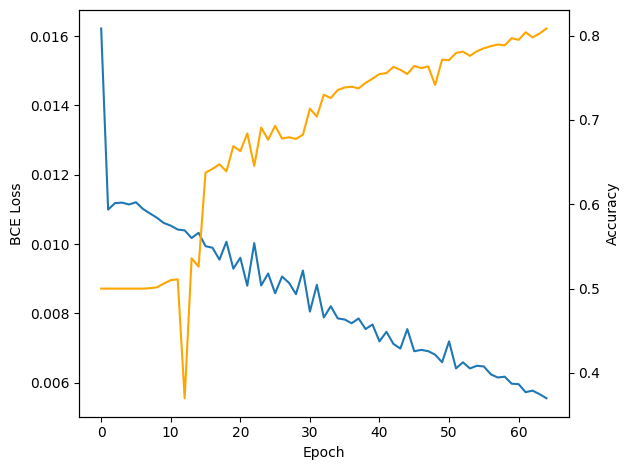

In [18]:
w2v = NN(300, 512)
print("Parameters:", w2v.count_parameters())
w2v, w2v_losses, w2v_accuracies = train(w2v, X_train, y_train, epochs=65)
plot_loss(w2v_losses, w2v_accuracies)

              precision    recall  f1-score   support

    negative       0.67      0.90      0.77      1000
    positive       0.85      0.55      0.67      1000

    accuracy                           0.73      2000
   macro avg       0.76      0.73      0.72      2000
weighted avg       0.76      0.73      0.72      2000

Accuracy: 0.7255


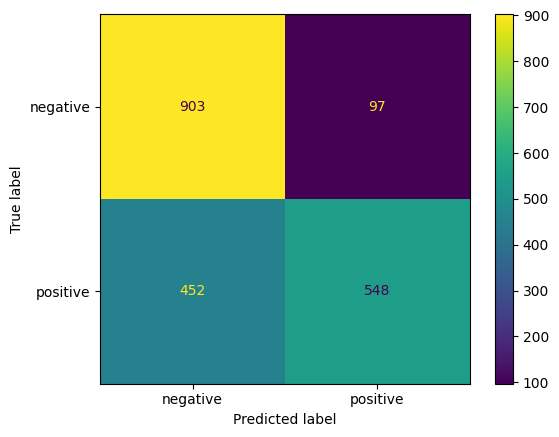

In [19]:
y_pred = predict(w2v, X_test)
score(y_test, y_pred)

**What can the model see with W2V and what can it see with TF-IDF?**

## BOW with Subword tokenization


**What happens if TF-IDF gets words that it didn't see during the training?**

A way to handle words not seen during training is to split words into smaller unit. In this way, it is more likely that the model has seen those units during trainig.

For example, in the test set there might be the word "goodd", which is completely different from the word "good". If "goodd" is split in "good" + "d", then the model can, at least partially, interpret it.

In [20]:
def train_sp(reviews: list[str], name: str="sp_tokenizer", vocab_size=1000):
    """This will train the tokenizer ans save it in {name}.model (and {name}.vocab)."""

    spm.SentencePieceTrainer.train(
        sentence_iterator=iter(reviews), # Use input to train sp from a file
        model_prefix=name,
        # What happens if you change the vocab_size?
        # (Not all values are possible, but SP will tell you)
        vocab_size=vocab_size,
        model_type="unigram" # you can try with bpe and word
    )

    # If you don't want to save it to a file you can use the following
    # model = io.BytesIO()
    # spm.SentencePieceTrainer.train(
    #     sentence_iterator=reviews,
    #     model_writer=model,
    #     vocab_size=1000,
    #     model_type="unigram"
    # )
    # return model

def load_sp(model="sp_tokenizer"):
    sp = spm.SentencePieceProcessor(model_file=f"{model}.model")
    # If you used io.BytesIO, you can load it like this:
    # sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
    return sp

This library can split the text into subword tokes and encode them.

This is an example from the documentation:
```python
>>> sp.encode(['This is a test', 'Hello world'], out_type=str)
[['▁This', '▁is', '▁a', '▁', 't', 'est'], ['▁He', 'll', 'o', '▁world']]

>>> sp.encode(['This is a test', 'Hello world'], out_type=int)
[[284, 47, 11, 4, 15, 400], [151, 88, 21, 887]]
````

SentencePiece will give us a sequence with variable length.

But since we are going to use a BOW, we only have to count how many times we see each token. So, each review is reprensented as a vector with shape (vocabulary size,).

In [21]:
# Train SentencePiece
vocab_size=1000
train_sp(train_df["review_text"].tolist(), vocab_size=vocab_size)
sp = load_sp()

# Now we have fixed vocabulry
vocabulary = {sp.id_to_piece(i): i for i in range(sp.get_piece_size())}

sp_vectorizer = TfidfVectorizer(
    lowercase=False,
    vocabulary=vocabulary,
    analyzer=sp.encode_as_pieces,
    binary=False,
    use_idf=False,
)

In [22]:
X_train = sp_vectorizer.fit_transform(train_df['review_text'].tolist()).toarray()
X_train = X_train.astype(np.float32)
X_test = sp_vectorizer.transform(test_df['review_text'].tolist()).toarray()
X_test = X_test.astype(np.float32)
y_train = train_df['review_score'].to_numpy(np.float32)
y_test = test_df['review_score'].to_numpy(np.float32)
print("Train dataset shape:", X_train.shape)
X_train

Train dataset shape: (2000, 1000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Most frequent terms: ['s', '.', 'ly', ',', '▁the', 't', '▁game', '▁a', '▁Ear', '▁Review']
Least frequent terms: ['▀', '▓', '的', '▄', '是', '▐', '▌', '<unk>', '<s>', '</s>']


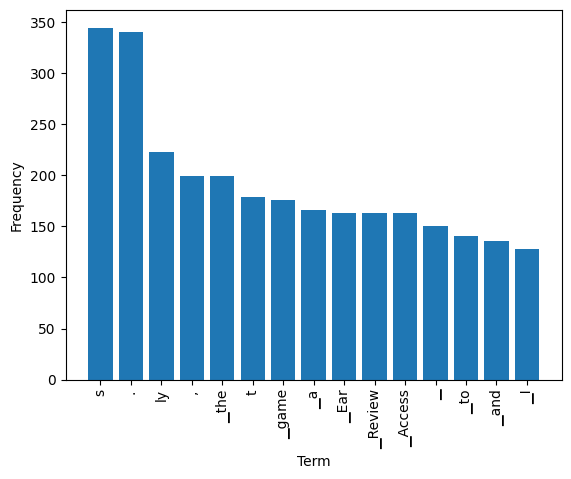

In [23]:
freq = X_train.sum(axis=0)
freq = [(f, sp.id_to_piece(i)) for i,f in enumerate(freq.flat)]
freq = sorted(freq, reverse=True)
print("Most frequent terms:", [i[1] for i in freq[:10]])
print("Least frequent terms:", [i[1] for i in freq[-10:]])

n = 15
plt.bar([i[1] for i in freq[:n]], [i[0] for i in freq[:n]])
plt.ylabel("Frequency")
plt.xlabel("Term")
plt.xticks(rotation=90)
plt.show()

Parameters: 322305


Epoch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

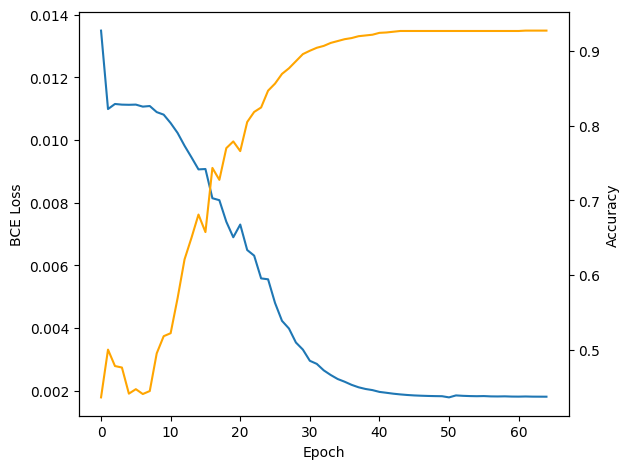

In [24]:
subword = NN(vocab_size, 256)
print("Parameters:", subword.count_parameters())
subword, subword_losses, subword_accuracies = train(subword, X_train, y_train, epochs=65)
plot_loss(subword_losses, subword_accuracies)

              precision    recall  f1-score   support

    negative       0.70      0.78      0.74      1000
    positive       0.75      0.67      0.71      1000

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000

Accuracy: 0.7215


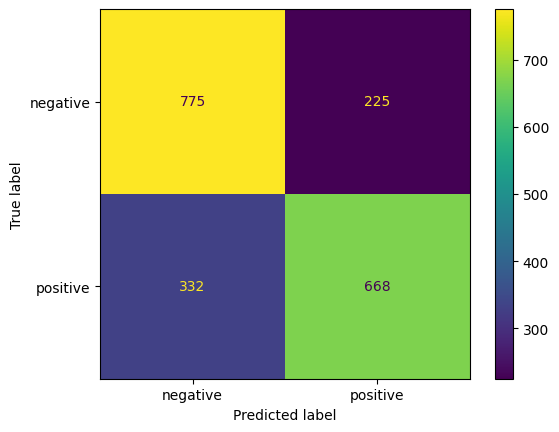

In [25]:
y_pred = predict(subword, X_test)
score(y_test, y_pred)

**What the model can see with SentencePiece?**

## Words

What happens if the review is in Czech? Can the model distinguish "This is not bad but good" from "This is not good but bad"?

In [26]:
example_review = [
    "To není dobré",
    "To je dobré",
    "This is not bad but really good.",
    "This is not good but really bad.",
    "Trallallero trallallà",
    "iT iS gOoD!!1!11!"
]
X_examples = tfidf_vectorizer.transform(example_review).toarray()
# X_examples = sp_vectorizer.transform(example_review).toarray()
# X_examples = embed(fasttext_embeddings, example_review)
y_examples = predict(bow, X_examples)


for r, y in  zip(example_review, y_examples):
    print(y, r)

0.1139778 To není dobré
0.1139778 To je dobré
0.08451483 This is not bad but really good.
0.08451483 This is not good but really bad.
0.17324609 Trallallero trallallà
0.1261311 iT iS gOoD!!1!11!


## Extra - Small recurrent network

These kind of models (RNN, LSTM, GRU) can take a sequence as input and consider the order of the tokens in the sentence. Compared to the models we used before, these might require more data to train.

In [27]:
def tokenize_sp(sp, reviews, n=150):
    encoded = [sp.encode_as_ids(review) for review in reviews]
    padded = []
    for enc in encoded:
        if len(enc) > n:
            pad = enc[:n]
        else:
            pad = [0] * (n - len(enc)) + enc # Pad with 0
        padded.append(pad)
    return torch.tensor(padded)

In [28]:
class SeqNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (n examples, seq length)
        x = self.emb(x.int())
        # x shape: (n examples, seq length, hidden dim)
        rnn_out, _ = self.rnn(x)
        last_hidden_state = rnn_out[:, -1, :]
        # shape: (n examples, seq length, hidden dim * 2)
        output = self.linear(last_hidden_state)
        return output

    def predict(self, X):
        """Return p(review is positive)"""
        return torch.sigmoid(self(X))

    def count_parameters(self):
        p = 0
        for parameter in self.parameters():
            p += parameter.numel()
        return p

In [29]:
X_train = tokenize_sp(sp, train_df['review_text'].tolist())
X_test = tokenize_sp(sp, test_df['review_text'].tolist())

y_train = train_df['review_score'].to_numpy(np.float32)
y_test = test_df['review_score'].to_numpy(np.float32)
print("Train dataset shape:", X_train.shape)
X_train

Train dataset shape: torch.Size([2000, 150])


tensor([[  0,   0,   0,  ..., 381,  98,   4],
        [107,  87,   8,  ..., 927,  15,  42],
        [  0,   0,   0,  ...,  25,  41, 555],
        ...,
        [167,  34,  16,  ..., 268,  82, 619],
        [  0,   0,   0,  ...,  22,  21,   4],
        [  0,   0,   0,  ...,  13,   5, 143]])

Parameters: 2088449


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

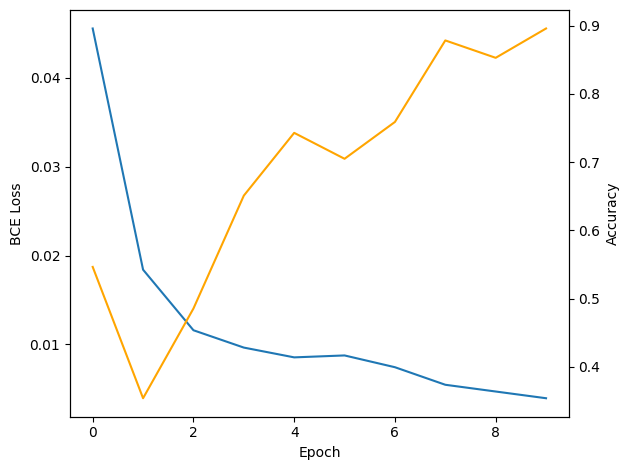

In [30]:
seqnn = SeqNN(vocab_size, 512)
print("Parameters:", seqnn.count_parameters())
seqnn, seqnn_losses, seqnn_accuracies = train(seqnn, X_train, y_train, epochs=10)
plot_loss(seqnn_losses, seqnn_accuracies)

              precision    recall  f1-score   support

    negative       0.55      0.47      0.50      1000
    positive       0.53      0.61      0.57      1000

    accuracy                           0.54      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.54      0.54      2000

Accuracy: 0.5395


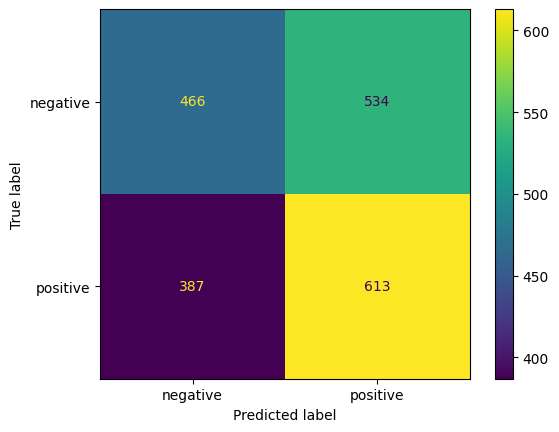

In [31]:
y_pred = predict(seqnn, X_test)
score(y_test, y_pred)